# Aritra Raut

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sklearn.datasets
from sklearn.model_selection import  train_test_split

In [3]:
# load load_breast_cancer
dat = sklearn.datasets.load_breast_cancer()
ix = np.where(dat["feature_names"] == "mean area")[0][0]
iy = np.where(dat["feature_names"] == "mean concave points")[0][0]

In [4]:
x0 = np.asarray([dat["data"][:,ix], dat["data"][:,iy], np.ones(dat["data"].shape[0])]).T
y0 = (1.*(dat["target"]==np.where(dat["target_names"] == "malignant")[0][0]) +
     0.0*(dat["target"]==np.where(dat["target_names"] == "benign")[0][0]))

In [5]:
# normalize (use StandardScaler if you wish)
def normalize_data(X, normalize_cols):
    mean_X = X[:,normalize_cols].mean(axis=0)
    std_X = X[:,normalize_cols].std(axis=0)
    X[:,normalize_cols] = (X[:,normalize_cols] - mean_X)/std_X
    return mean_X, std_X

def unnormalize_theta(theta, normalize_cols, mean_std):
    theta[normalize_cols] /= mean_std[1]
    theta[-1] -= theta[normalize_cols] @ mean_std[0]

In [6]:
# partition with test size 0.3
X_train, X_test, y_train, y_test = train_test_split(x0, y0, test_size=0.3, random_state=42)


In [7]:
# fit logistic regression and draw ROC curve
# use predict_log_proba()
def h(x,theta):
    sum2=0
    for i in range(len(theta)):
        sum2+=x[i]*theta[i]
    return 1/(1+np.exp(-sum2)) 

def logistic(x,y):
    theta=np.zeros(x.shape[1])
    alpha=1
    m=len(x)
    for i in range(len(theta)):
        for k in range(1000):
            sum1=0
            for j in range(m):
                sum1+=(h(x[j,:],theta)-y[j])*x[j,i]
            theta[i]+=alpha*sum1
    return theta

In [8]:
X, y = X_train.copy(), y_train.copy()
mean_std = normalize_data(X, [True, True, False])
theta= logistic(X,y)
unnormalize_theta(theta, [True, True, False], mean_std)
print(theta)


/home/sysadm/Documents/datascience/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


[-7.82050936e+02 -7.96569073e+06  1.01424189e+06]


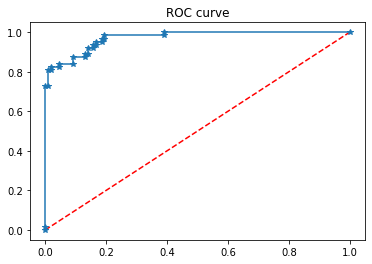

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, accuracy_score, precision_recall_curve, f1_score

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
ns_probs =[0 for _ in range(len(y_test))]
#predict probabilities
lr_probs = log_reg.predict_log_proba(X_test)
lr_probs= lr_probs[:,1]
# use predict_log_proba()

#calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test,ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

plt.title("ROC curve")
plt.plot(ns_fpr,ns_tpr,'r--')
plt.plot(lr_fpr,lr_tpr, marker='*')
plt.show()

In [ ]:
def plot_classification(theta):
    x_range = [0,2600]
    y_range = [0, 0.21]

    # plot classifcation regions
    grid=200
    xx,yy = np.meshgrid(np.linspace(x_range[0], x_range[1], grid),
                        np.linspace(y_range[0], y_range[1], grid))
    X_ = np.array([np.ravel(xx), np.ravel(yy), np.ones(xx.size)]).T
    zz = (X_ @ theta).reshape(grid,grid)
    cs = plt.contourf(xx,yy,zz, zz,levels=[-100.0,0,100.0],alpha=0.2)
    plt.contour(cs, colors='k')

    s1 = plt.scatter(dat["data"][:,ix][dat["target"]==1], dat["data"][:,iy][dat["target"]==1], marker='x', color='C0')
    s2 = plt.scatter(dat["data"][:,ix][dat["target"]==0], dat["data"][:,iy][dat["target"]==0], marker='+', color='C3')
    plt.xlim([0,2600])
    plt.ylim([0,0.21])
    plt.xlabel("Mean Area")
    plt.ylabel("Mean Concave Points")
    plt.legend([s1,s2], ['Benign', 'Malignant'])

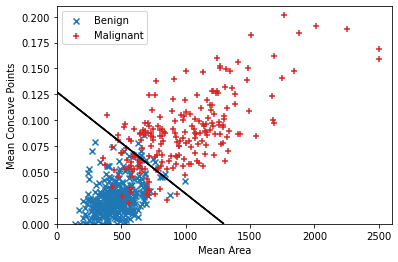

In [32]:
plot_classification(theta)

In [ ]:
# What happens to the "score" when C = 1, 1/10, 1/50, 1/100, 1/1000?
C_param_range = [1,1/10,1/50,1/100,1/1000]

acc_table = pd.DataFrame(columns = ['C_parameter','Accuracy'])
acc_table['C_parameter'] = C_param_range

j = 0
for i in C_param_range:
    
    # Apply logistic regression model to training data
    lr = LogisticRegression(penalty = 'l2', C = i,random_state = 42)
    lr.fit(X_train,y_train)
    
    # Predict using model
    y_pred = lr.predict(X_test)
    
    # Saving accuracy score in table
    acc_table.iloc[j,1] = accuracy_score(y_test,y_pred)
    j += 1

print(acc_table)    